# WZE-UAV Image Classification using Deep Learning

In [1]:
import os
import gc
import glob
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix

In [3]:
import wze_uav.data_loader as data_loader
import wze_uav.models as models
from wze_uav.engine import *
from wze_uav.utils2 import *
from wze_uav.log_writer import create_writer
from wze_uav.datasplit import *
from efficientnet import model_effnet #for custom effnet with n_channels input

#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [5]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    # seed for numpy
    np.random.seed(seed)

set_seeds() 

# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = False


#### Define file directory

In [7]:
#####################################################################################
# 3 channel input (r-g-b)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb"

# 4 channel input (r-g-b-nir)
data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-nir"

# 5 channel input (r-g-b-re-nir)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-re-nir"
#####################################################################################

#### Get all file paths

In [8]:
fn_list = os.listdir(data_path)
path_list = []
# Iterate over all datafiles
for year in fn_list:
    year_dir = f'{data_path}\\{year}'
    for filename in os.listdir(year_dir):
        path = f'{year_dir}\\{filename}'
        path_list.append(path)

#### Create unique hash IDs for every individual tree

In [9]:
hashID_dict = data_loader.get_unique_treeID(path_list)

Creating unique tree IDs...:   0%|          | 0/647 [00:00<?, ?it/s]

#### Import all imagery, labels and other features from hdf5 files

In [10]:
image_set, label_set, species_set, kkl_set, bk_set, hash_id = data_loader.hdf5_to_img_label_v2(path_list,
                                                                                               hashID_dict,
                                                                                               load_sets=["images_masked"])

Processing hdf5 datasets:   0%|          | 0/647 [00:00<?, ?it/s]

#### Convert nbv to classes

In [11]:
label_set = nbv_to_sst_3classes(label_set)

#### Split data and seperate a test dataset

In [12]:
image_set, label_set, hash_id, species_set, test_image_set, test_label_set, test_hash_id, test_species_set = data_split(image_set, label_set, hash_id, species_set, test_size=0.15, random_state=42)


There are 7087 unique values within hash_id.
Check shapes:

Images train dataset: (15973, 250, 250, 4)
Labels train dataset: (15973, 1)

Images test dataset: (2832, 250, 250, 4)
Labels test dataset: (2832, 1)

--------------------------------------------------
Check if the split was stratified: (random_state=42)
Healthy trees in train dataset: 14465
Stressed trees in train dataset: 1240
Dead trees in train dataset: 268
Healthy trees in test dataset: 2551
Stressed trees in test dataset: 237
Dead trees in test dataset: 44
Ratio health trees in test dataset: 0.1499177244945933
Ratio stressed trees in test dataset: 0.16046039268788084
Ratio dead trees in test dataset: 0.14102564102564102


#### Check if any hash ID is in both train and test dataset

In [13]:
hash_set = set(hash_id.flatten())
test_hash_set = set(test_hash_id.flatten())
intersection = hash_set.intersection(test_hash_set)
if intersection:
    print(f"Hash_id values in both train and test sets: {intersection}")
else:
    print("There are no hash_id values in both train and test datasets. The datasplit was successful")

There are no hash_id values in both train and test datasets. The datasplit was successful


#### Check feature distribution of the Test dataset

In [14]:
def count_occurrences(data, value):
    count = 0
    for item in data:
        if item == value:
            count += 1
    return count

print("Test dataset")
print(f"Test data healthy trees: {count_occurrences(test_label_set, 0)}")
print(f"Test data stressed trees: {count_occurrences(test_label_set, 1)}")
print(f"Test data dead trees: {count_occurrences(test_label_set, 2)}")
print(f"Test data pine trees: {count_occurrences(test_species_set, 134)}")
print(f"Test data spruces: {count_occurrences(test_species_set, 118)}")
print("-"*50)

print("Remaining dataset")
print(f"Remaining data healthy trees: {count_occurrences(label_set, 0)}")
print(f"Remaining data stressed trees: {count_occurrences(label_set, 1)}")
print(f"Remaining data dead trees: {count_occurrences(label_set, 2)}")
print(f"Remaining data pine trees: {count_occurrences(species_set, 134)}")
print(f"Remaining data spruces: {count_occurrences(species_set, 118)}")
print("-"*50)

Test dataset
Test data healthy trees: 2551
Test data stressed trees: 237
Test data dead trees: 44
Test data pine trees: 755
Test data spruces: 1041
--------------------------------------------------
Remaining dataset
Remaining data healthy trees: 14465
Remaining data stressed trees: 1240
Remaining data dead trees: 268
Remaining data pine trees: 4036
Remaining data spruces: 5942
--------------------------------------------------


In [15]:
# train transform with augmentation. 
transform_train = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(degrees=[0,360])])

# test and val dataset transform without augmentation. 
transform = transforms.Compose([transforms.ToTensor()])

# class names need to fit the customDataset class used e.g. 3 classes -> use CustomDataset3Classes
#class_names = ['healthy', 'slightly_stressed', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['healthy', 'moderately_stressed', 'highly_stressed', 'dead']
class_names = ['healthy', 'stressed', 'dead']

# set seeds
g = torch.Generator()
g.manual_seed(42)
NUM_WORKERS=3 # should be changed, depending on the system used
batch_size=32

#### Define variables and parameters

In [16]:
# 1. Define number of epochs
epochs = 50
n_bands = image_set[0].shape[2] # get number of bands

# 2. Define model
num_classes = len(class_names)
unfreeze = True # all layer weights get updated
dropout_rate = 0.45 #define dropout rate
model_name = "EffNet_b7_RGB-NIR_3classes"

# 3. Define loss, optimizer and learning rate scheduler
lr = 0.0011 # define learning rate
min_lr = 1e-5 # minimum learning rate threshold
gamma = 0.85 # how fast the learning rate decreases per epoch (low number=faster decrease)
patience = 10

# 4. Create target folder name were to save the tensorboard event files

experiment_name = 'RGB-NIR_3classes'
extra = ""

#----------------------------------------------------------------------
#torch.cuda.empty_cache()
print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes") 



Memory allocated: 0 bytes


#### Run k-Fold cross-validation on EfficientNet

In [17]:
%%time

# Set the random seeds
set_seeds(42)

# Define the number of folds
num_folds = 5

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

unique_values = np.unique(hash_id) # now there are less unique values left because we seperated the test dataset
num_unique = len(unique_values)
print(f"There are {num_unique} unique values within hash_id.\n")

# Loop over each fold
for fold, (train_ids, val_ids) in enumerate(kf.split(unique_values)):
    torch.cuda.empty_cache()
    
    # 1. Split data into train and validation set
    # Get the training and testing data for this fold
    # Use np.isin() to create boolean arrays indicating which indices belong to train or test sets
    train_indices = np.isin(hash_id, unique_values[train_ids])
    val_indices = np.isin(hash_id, unique_values[val_ids])
    
    # Reshape boolean arrays to match shape of image_set and label_set
    train_indices = train_indices.reshape(-1, 1)
    val_indices = val_indices.reshape(-1, 1)
  
    # Select images and labels for train and validation sets
    train_image_set = image_set[train_indices[:, 0]]
    train_label_set = label_set[train_indices[:, 0]]
    train_hash_id = hash_id[train_indices[:, 0]]
    train_species_set = species_set[train_indices[:, 0]]
    val_image_set = image_set[val_indices[:, 0]]
    val_label_set = label_set[val_indices[:, 0]]
    val_hash_id = hash_id[val_indices[:, 0]]
    val_species_set = species_set[val_indices[:, 0]]
    train_label_set = train_label_set.reshape(-1, 1)
    val_label_set = val_label_set.reshape(-1, 1)
    train_hash_id = train_hash_id.reshape(-1, 1)
    val_hash_id = val_hash_id.reshape(-1, 1)
    train_species_set = train_species_set.reshape(-1, 1)
    val_species_set = val_species_set.reshape(-1, 1)
            
    print("Check shapes:\n")
    print(f"Images train dataset: {train_image_set.shape}")
    print(f"Labels train dataset: {train_label_set.shape}\n")
    
    print(f"Images validation dataset: {val_image_set.shape}")
    print(f"Labels validation dataset: {val_label_set.shape}\n")
    print('-'*50)
    print (f"Check if the split was stratified: (random_state=42)")
    print(f"Healthy trees in train dataset: {np.count_nonzero(train_label_set == 0)}")
    print(f"Stressed trees in train dataset: {np.count_nonzero(train_label_set == 1)}")
    print(f"Dead trees in train dataset: {np.count_nonzero(train_label_set == 2)}")
    print(f"Healthy trees in validation dataset: {np.count_nonzero(val_label_set == 0)}")
    print(f"Stressed trees in validation dataset: {np.count_nonzero(val_label_set == 1)}")
    print(f"Dead trees in validation dataset: {np.count_nonzero(val_label_set == 2)}")
    print(f"Ratio health trees in validation dataset: {np.count_nonzero(val_label_set == 0)/np.count_nonzero(label_set == 0)}")
    print(f"Ratio stressed trees in validation dataset: {np.count_nonzero(val_label_set == 1)/np.count_nonzero(label_set == 1)}")
    print(f"Ratio dead trees in validation dataset: {np.count_nonzero(val_label_set == 2)/np.count_nonzero(label_set == 2)}")
    print("-"*50)
    
    
    # 2. Create train and validation dataset. (choose custom dataset loader with 3 - 5 classes)
    print(f"\nCreating datasets for fold: {fold + 1}\n")
    train_dataset = data_loader.CustomDataset(data=train_image_set, labels=train_label_set, class_names=class_names, species = train_species_set,
                                                         transform=transform_train)
    
    val_dataset = data_loader.CustomDataset(data=val_image_set, labels=val_label_set, class_names=class_names,
                                                       species = val_species_set, transform=transform)
   
    # 3. Create train and validation dataloader
    # create sampler for oversampling of the minority classes
    sampler = data_loader.data_sampler(dataset=train_dataset, class_names=class_names)
    print(f"Creating dataloaders for fold: {fold +1}\n")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, persistent_workers=True, pin_memory=True, num_workers=NUM_WORKERS, generator=g,
                              sampler=sampler, shuffle=False, drop_last=True) # shuffle false because of the sampler

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, persistent_workers=True, pin_memory=True, num_workers=NUM_WORKERS, shuffle=False,
                             drop_last=True)
    
    model = model_effnet.EfficientNet.from_pretrained('efficientnet-b7', in_channels=n_bands, num_classes=num_classes, dropout_rate=dropout_rate)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    #lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    lr_scheduler = ExponentialLR(optimizer, gamma=gamma)

    fold += 1
    print(f"\n[INFO] Fold number: {fold}")
    print(f"[INFO] Number of epochs: {epochs}")
    print(f"[INFO] Batch_size: {batch_size}")
    print(f"[INFO] Number of bands: {n_bands}")
    print(f"[INFO] Dropout rate: {dropout_rate}")
    print(f"[INFO] Gamma learning rate: {gamma}")
    print(f"[INFO] Memory allocated: {torch.cuda.memory_allocated()} bytes")
    # 4. Train model with k fold dataloaders and track experiments
    if fold == 1:
        fold1_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=create_writer(experiment_name=experiment_name, model_name=model_name, extra=extra), early_stop_patience = patience)
       
    elif fold == 2:
        fold2_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=create_writer(experiment_name=experiment_name, model_name=model_name, extra=extra), early_stop_patience = patience)
    elif fold == 3:
        fold3_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=create_writer(experiment_name=experiment_name, model_name=model_name, extra=extra), early_stop_patience = patience)
    elif fold == 4:
        fold4_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=create_writer(experiment_name=experiment_name, model_name=model_name, extra=extra), early_stop_patience = patience)
    else:
        fold5_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=create_writer(experiment_name=experiment_name, model_name=model_name, extra=extra), early_stop_patience = patience)
    
    del train_indices, val_indices, train_image_set, train_label_set, train_hash_id, train_species_set, val_image_set, val_label_set, val_hash_id, val_species_set,
    train_dataset, val_dataset, sampler, train_dataloader, val_dataloader, model, loss_fn, optimizer, lr_scheduler

    print("Deleting variables and emptying cache")
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes")
    print("-"*50 + "\n")

There are 6023 unique values within hash_id.

Check shapes:

Images train dataset: (12770, 250, 250, 4)
Labels train dataset: (12770, 1)

Images validation dataset: (3203, 250, 250, 4)
Labels validation dataset: (3203, 1)

--------------------------------------------------
Check if the split was stratified: (random_state=42)
Healthy trees in train dataset: 11550
Stressed trees in train dataset: 983
Dead trees in train dataset: 237
Healthy trees in validation dataset: 2915
Stressed trees in validation dataset: 257
Dead trees in validation dataset: 31
Ratio health trees in validation dataset: 0.20152091254752852
Ratio stressed trees in validation dataset: 0.20725806451612902
Ratio dead trees in validation dataset: 0.11567164179104478
--------------------------------------------------

Creating datasets for fold: 1

Creating dataloaders for fold: 1

Loaded pretrained weights for efficientnet-b7

[INFO] Fold number: 1
[INFO] Number of epochs: 50
[INFO] Batch_size: 32
[INFO] Number of bands

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
Learning rate: 0.0011
Train loss: 0.6796 | Train precision: 0.6858 | Train recall: 0.6857 | Train f1score: 0.6849 | Train acc: 0.6718 | Train kappa: 0.6034 
Val loss: 0.4010 | Val precision: 0.4504 | Val recall: 0.4178 | Val f1score: 0.4224 | Val acc: 0.8791 | Val kappa: 0.3248 

Epoch: 2 
Learning rate: 0.0009350000000000001
Train loss: 0.5764 | Train precision: 0.7564 | Train recall: 0.7572 | Train f1score: 0.7565 | Train acc: 0.7269 | Train kappa: 0.6818 
Val loss: 0.5942 | Val precision: 0.4680 | Val recall: 0.7599 | Val f1score: 0.5166 | Val acc: 0.7900 | Val kappa: 0.3660 

Epoch: 3 
Learning rate: 0.00079475
Train loss: 0.5359 | Train precision: 0.7872 | Train recall: 0.7809 | Train f1score: 0.7840 | Train acc: 0.7480 | Train kappa: 0.7002 
Val loss: 0.4548 | Val precision: 0.5979 | Val recall: 0.7942 | Val f1score: 0.6381 | Val acc: 0.7641 | Val kappa: 0.3534 

Epoch: 4 
Learning rate: 0.0006755375
Train loss: 0.5160 | Train precision: 0.7934 | Train recall: 0.7893 | 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
Learning rate: 0.0011
Train loss: 0.6801 | Train precision: 0.6812 | Train recall: 0.6838 | Train f1score: 0.6823 | Train acc: 0.6635 | Train kappa: 0.5702 
Val loss: 0.4935 | Val precision: 0.6951 | Val recall: 0.3731 | Val f1score: 0.3755 | Val acc: 0.8684 | Val kappa: 0.3344 

Epoch: 2 
Learning rate: 0.0009350000000000001
Train loss: 0.5787 | Train precision: 0.7611 | Train recall: 0.7566 | Train f1score: 0.7587 | Train acc: 0.7198 | Train kappa: 0.6589 
Val loss: 0.6708 | Val precision: 0.7034 | Val recall: 0.5342 | Val f1score: 0.4234 | Val acc: 0.5669 | Val kappa: 0.1919 

Epoch: 3 
Learning rate: 0.00079475
Train loss: 0.5565 | Train precision: 0.7748 | Train recall: 0.7678 | Train f1score: 0.7713 | Train acc: 0.7298 | Train kappa: 0.6659 
Val loss: 0.8578 | Val precision: 0.6375 | Val recall: 0.6253 | Val f1score: 0.4090 | Val acc: 0.2276 | Val kappa: 0.1011 

Epoch: 4 
Learning rate: 0.0006755375
Train loss: 0.5303 | Train precision: 0.7891 | Train recall: 0.7799 | 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
Learning rate: 0.0011
Train loss: 0.6742 | Train precision: 0.6904 | Train recall: 0.6933 | Train f1score: 0.6918 | Train acc: 0.6811 | Train kappa: 0.5823 
Val loss: 0.4081 | Val precision: 0.7294 | Val recall: 0.4566 | Val f1score: 0.5017 | Val acc: 0.8984 | Val kappa: 0.4660 

Epoch: 2 
Learning rate: 0.0009350000000000001
Train loss: 0.5820 | Train precision: 0.7517 | Train recall: 0.7544 | Train f1score: 0.7530 | Train acc: 0.7232 | Train kappa: 0.6539 
Val loss: 0.2900 | Val precision: 0.7046 | Val recall: 0.7169 | Val f1score: 0.7100 | Val acc: 0.8914 | Val kappa: 0.6292 

Epoch: 3 
Learning rate: 0.00079475
Train loss: 0.5571 | Train precision: 0.7712 | Train recall: 0.7667 | Train f1score: 0.7689 | Train acc: 0.7395 | Train kappa: 0.6674 
Val loss: 0.3977 | Val precision: 0.6461 | Val recall: 0.7653 | Val f1score: 0.6842 | Val acc: 0.8438 | Val kappa: 0.5659 

Epoch: 4 
Learning rate: 0.0006755375
Train loss: 0.5313 | Train precision: 0.7864 | Train recall: 0.7836 | 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
Learning rate: 0.0011
Train loss: 0.6848 | Train precision: 0.6742 | Train recall: 0.6730 | Train f1score: 0.6731 | Train acc: 0.6602 | Train kappa: 0.5704 
Val loss: 0.6902 | Val precision: 0.7078 | Val recall: 0.5753 | Val f1score: 0.5071 | Val acc: 0.6515 | Val kappa: 0.2520 

Epoch: 2 
Learning rate: 0.0009350000000000001
Train loss: 0.5933 | Train precision: 0.7410 | Train recall: 0.7447 | Train f1score: 0.7428 | Train acc: 0.7169 | Train kappa: 0.6541 
Val loss: 0.5847 | Val precision: 0.5622 | Val recall: 0.7640 | Val f1score: 0.5806 | Val acc: 0.6733 | Val kappa: 0.3242 

Epoch: 3 
Learning rate: 0.00079475
Train loss: 0.5564 | Train precision: 0.7688 | Train recall: 0.7681 | Train f1score: 0.7683 | Train acc: 0.7336 | Train kappa: 0.6894 
Val loss: 0.4322 | Val precision: 0.6706 | Val recall: 0.7554 | Val f1score: 0.6864 | Val acc: 0.8207 | Val kappa: 0.4820 

Epoch: 4 
Learning rate: 0.0006755375
Train loss: 0.5414 | Train precision: 0.7762 | Train recall: 0.7744 | 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
Learning rate: 0.0011
Train loss: 0.6864 | Train precision: 0.6839 | Train recall: 0.6870 | Train f1score: 0.6850 | Train acc: 0.6712 | Train kappa: 0.5803 
Val loss: 0.3105 | Val precision: 0.6990 | Val recall: 0.4525 | Val f1score: 0.4904 | Val acc: 0.9041 | Val kappa: 0.2502 

Epoch: 2 
Learning rate: 0.0009350000000000001
Train loss: 0.5927 | Train precision: 0.7463 | Train recall: 0.7532 | Train f1score: 0.7494 | Train acc: 0.7265 | Train kappa: 0.6683 
Val loss: 0.4841 | Val precision: 0.6343 | Val recall: 0.7625 | Val f1score: 0.6684 | Val acc: 0.7969 | Val kappa: 0.4358 

Epoch: 3 
Learning rate: 0.00079475
Train loss: 0.5487 | Train precision: 0.7749 | Train recall: 0.7751 | Train f1score: 0.7750 | Train acc: 0.7408 | Train kappa: 0.6858 
Val loss: 0.3838 | Val precision: 0.7055 | Val recall: 0.7232 | Val f1score: 0.6939 | Val acc: 0.8281 | Val kappa: 0.4769 

Epoch: 4 
Learning rate: 0.0006755375
Train loss: 0.5262 | Train precision: 0.7919 | Train recall: 0.7920 | 

In [ ]:
# create test dataset
test_dataset = data_loader.CustomDataset3Classes(
    data = test_image_set,
    labels = test_label_set,
    class_names=class_names, 
    species = test_species_set,
    kkl = test_kkl_set,
    transform=transform
)

# create test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=True)

In [60]:
# Setup the best model filepath
best_model_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\effnet_b0\01_18_epochs.pth"

# Instantiate a new instance of EffNetB0 (to load the saved state_dict() to)
unfreeze=True
best_model = models.create_effnetb0(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnet_b0 model.


<All keys matched successfully>

In [61]:
def make_predictions(model: torch.nn.Module, 
                     test_dataloader: torch.utils.data.DataLoader,
                     device: torch.device):
    # 1. Make predictions with trained model
    y_preds = []
    y_labels = []
    test_loss, test_precision, test_recall, test_f1_score, test_acc = 0, 0, 0, 0, 0
    count = 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())
            y_labels.append(y.cpu())
            
            #other metrics
            test_acc += ((y_pred == y).sum().item()/len(y_pred))
            y_pred_class = y_pred.detach().cpu().numpy() 
            y_class = y.detach().cpu().numpy()
            labels = np.array([0])
            test_precision += precision_score(y_class, y_pred_class, average='macro', zero_division=0, labels=[0,1,2])
            test_recall += recall_score(y_class, y_pred_class, average='macro', zero_division=0, labels=[0,1,2])
            #test_f1_score += f1_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
            
            #if count >= 1:
            #    y_set = torch.cat((y_set, y))
            #    count = count + 1
            #else:
            #    y_set = y
            #    count = count + 1
            
    test_loss = test_loss / len(test_dataloader)
    test_precision = test_precision / len(test_dataloader)
    test_recall = test_recall / len(test_dataloader)
    test_f1_score = test_f1_score / len(test_dataloader)
    #test_kappa = test_kappa / len(dataloader)
    test_acc = test_acc / len(test_dataloader)
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    y_labels_tensor = torch.cat(y_labels)
    test_f1_score = f1_score(y_labels_tensor.detach().cpu().numpy(), y_pred_tensor.cpu().numpy(), average='macro', zero_division=1, labels=[0,1,2])
    
    # Print classification report
    y_true = y_labels_tensor.detach().cpu().numpy()
    report = classification_report(y_true, y_pred_tensor.cpu().numpy(), target_names=class_names)
    print(report)
    
    return y_pred_tensor, y_labels_tensor, test_loss, test_recall, test_precision, test_f1_score, test_acc, y_logit, y_pred, y, y_preds

Making predictions:   0%|          | 0/156 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     healthy       0.95      0.88      0.92      2228
    stressed       0.32      0.56      0.41       226
        dead       0.84      0.86      0.85        42

    accuracy                           0.85      2496
   macro avg       0.70      0.77      0.72      2496
weighted avg       0.89      0.85      0.87      2496

Test loss: 0.0
Test precision: 0.4154684139459786
Test recall: 0.41671078506014464
Test F1score: 0.7247865216737815
Test Accuracy: 0.8525641025641025
Test Logits: tensor([[ 1.7014,  0.8877, -5.1889],
        [ 2.3632,  0.8889, -6.1630],
        [ 2.2219,  0.9962, -6.0906],
        [-0.6744,  0.1306,  0.6790],
        [ 0.9584,  1.0023, -4.1342],
        [ 1.1653,  0.9413, -4.2456],
        [ 1.9196,  1.0043, -5.6535],
        [ 0.5722,  0.7214, -2.7888],
        [ 2.0116,  1.1527, -6.1480],
        [ 2.0599,  1.0727, -6.0320],
        [ 2.1480,  0.9218, -5.8122],
        [ 1.8820,  0.8687, -5.2790],
        [ 1.

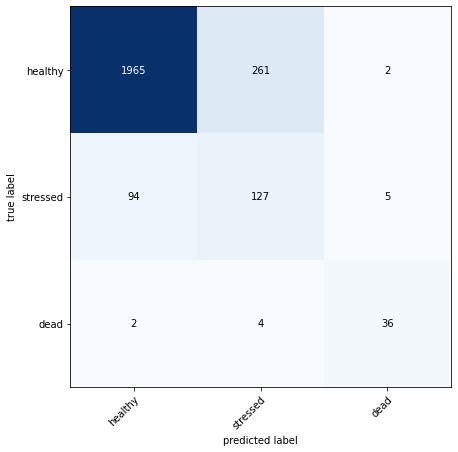

In [62]:
# 2. Setup confusion matrix instance and compare predictions to targets
#from wze_uav.analysis import *
y_pred_tensor, y_labels_tensor, test_loss, test_recall, test_precision, test_f1_score, test_acc, y_logit, y_pred, y, y_preds = make_predictions(model=best_model,
                                 test_dataloader=test_dataloader, 
                                 device=device)

y_labels_tensor = y_labels_tensor.detach().cpu().numpy()
y_pred_tensor = y_pred_tensor.detach().cpu().numpy()

#confmat = ConfusionMatrix(num_classes=num_classes, task='multiclass')
#confmat_tensor = confmat(preds=y_pred_tensor,
#                         target=test_labels)
labels = np.array([0,1,2])
confmat = confusion_matrix(y_labels_tensor, y_pred_tensor, labels=labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

print(f"Test loss: {test_loss}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1score: {test_f1_score}")
#print(f"Test Kappa: {test_kappa}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Logits: {y_logit}")
print(f"Test Predictions: {y_pred}")
print(f"Test Labels: {y}")

In [48]:
len(y_preds)

156

In [92]:
y_set.cpu()

NameError: name 'y_set' is not defined

In [141]:
test_dataset.labels

tensor([1, 0, 1,  ..., 0, 0, 0])

In [139]:
y_preds = []
y_labels = []
labels = np.array([0,1,2])
test_loss, test_precision, test_recall, test_f1_score, test_acc = 0, 0, 0, 0, 0
count = 0
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_labels.append(y.cpu())
        
        #other metrics
        test_acc += ((y_pred == y).sum().item()/len(y_pred))
        y_pred_class = y_pred.detach().cpu().numpy() 
        y_class = y.detach().cpu().numpy()
        test_precision += precision_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        test_recall += recall_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        #test_f1_score += f1_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        
        #if count >= 1:
        #    y_set = torch.cat((y_set, y))
        #    count = count + 1
        #else:
        #    y_set = y
        #    count = count + 1
        
test_loss = test_loss / len(test_dataloader)
test_precision = test_precision / len(test_dataloader)
test_recall = test_recall / len(test_dataloader)
#test_f1_score = test_f1_score / len(test_dataloader)
#test_kappa = test_kappa / len(dataloader)
test_acc = test_acc / len(test_dataloader)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
test_f1_score = f1_score(y_set.detach().cpu().numpy(), y_pred_tensor.cpu().numpy(), average='macro', zero_division=0, labels=[0,1,2])

# Print classification report
y_true = y_set.detach().cpu().numpy()
report = classification_report(y_true, y_pred_tensor.cpu().numpy(), target_names=class_names)
print(report)

Making predictions:   0%|          | 0/156 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     healthy       0.94      0.90      0.92      2228
    stressed       0.42      0.31      0.35       226
        dead       0.19      0.83      0.32        42

    accuracy                           0.85      2496
   macro avg       0.52      0.68      0.53      2496
weighted avg       0.88      0.85      0.86      2496



In [140]:
test_f1_score

0.528680154128826

In [122]:
make = (y_class == y_pred_class)
make

array([ True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True])

In [99]:
torch.softmax(y_logit, dim=1).argmax(dim=1)

tensor([0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [101]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [112]:
test = (y_pred == y).sum().item()/16

In [113]:
test

0.8125

In [114]:
 y_pred_class = y_pred.detach().cpu().numpy() 

In [115]:
y_pred_class

array([0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)